<a href="https://colab.research.google.com/github/Natalia409634/Grupo7-practica1-ML/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

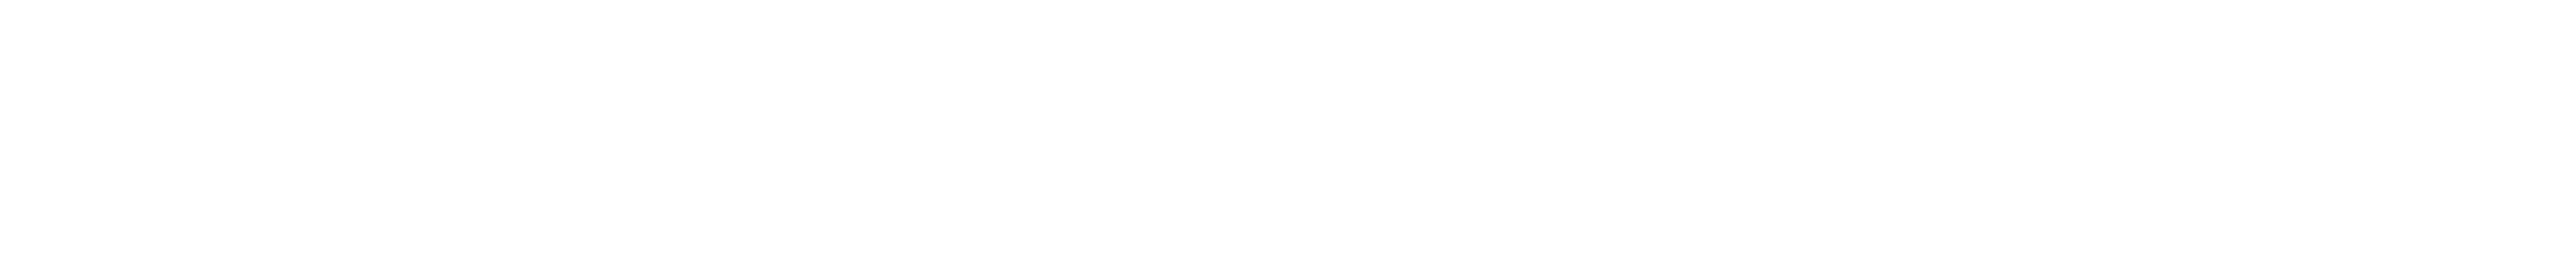

# **PRÁCTICA 1: PREDICCIÓN DE LA ENERGÍA SOLAR**


*   Aprendizaje Automático - Grupo 7
*   Andrés Felipe Camacho Martínez - 100408821
*   Natalia Jiménez Barrigüete - 100409634

# Librerías y lectura de datos

In [2]:
!pip install fitter
!pip install statsmodels
!pip install --upgrade linear-tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25608 sha256=21372c2e5cdbd0ca9f6f56be5597420541ae04c8c25d0877088776459e19ff36
  Stored in directory: /root/.cache/pip/wheels/2f/4b/12/1c9085f8ecb92805ca8645ab9c61703a2874685a9fb87b0bdb
Successfully built fitter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Configuraciones
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')
import time

# Tratamiento de datos
# ==============================================================================
import pandas as pd   
import numpy as np

# Gráficos
# ==============================================================================
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Preprocesado
# ==============================================================================
from fitter import Fitter, get_common_distributions
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, KFold

# Modelado
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lectura de datos

In [4]:
disp_df, comp_df = [pd.read_csv(f, compression="bz2", index_col=0) for f in 
                    ["/content/drive/MyDrive/Aprendizaje Automático/datos practica/disp_st7ns1.txt.bz2",
                     "/content/drive/MyDrive/Aprendizaje Automático/datos practica/comp_st7ns1.txt.bz2"]]

In [5]:
from sklearn.model_selection import train_test_split

X = disp_df.drop(columns = ['salida'])
y = disp_df[['salida']]

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.67, random_state=7)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=7)

# Modelo Final

In [6]:
# Quitar comentario si se quiere evaluar el modelo
from scipy.stats import randint as sp_randint

param_grid = {'n_estimators': sp_randint(10,100),
              'max_features': sp_randint(1,X.shape[1]),
              'max_depth': [10, 20, 40, None],
              'bootstrap': [True, False]}

inner = KFold(n_splits=3, shuffle=True, random_state=7)

rf = RandomForestRegressor(random_state=7)

budget = 20
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
regr_rf = RandomizedSearchCV(rf, 
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         refit=True,
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )

In [7]:
start_time = time.time()

regr_rf.fit(X_train, y_train.values.ravel())

opt_time_rf = time.time() - start_time

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [8]:
print(f"Best params: {regr_rf.best_params_}, best score (inner!): {np.sqrt(-regr_rf.best_score_)}")

Best params: {'bootstrap': False, 'max_depth': None, 'max_features': 5, 'n_estimators': 68}, best score (inner!): 3185883.286768359


In [9]:
y_rft = regr_rf.predict(X_test)

# We compute accuracy
opt_rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_rft))
opt_mae_rf = metrics.mean_absolute_error(y_test, y_rft)
opt_r2_rf = metrics.r2_score(y_test, y_rft)

print(f"RMSE of Random Forest óptimo: {opt_rmse_rf}")
print(f"MAE of Random Forest óptimo: {opt_mae_rf}")
print(f"R2 of Random Forest óptimo: {opt_r2_rf}")
print(f"Time of Random Forest óptimo: {opt_time_rf} \n")

RMSE of Random Forest óptimo: 3168825.777154723
MAE of Random Forest óptimo: 2143757.4207957047
R2 of Random Forest óptimo: 0.8496782116978688
Time of Random Forest óptimo: 157.21911692619324 



In [10]:
modelo_final = regr_rf.best_estimator_
# Entrenamos con todos los datos para el modelo final
_ = modelo_final.fit(X, y)

<ipython-input-10-b05958857dd2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  _ = modelo_final.fit(X, y)


In [11]:
_.predict(comp_df)

array([11733979.41176471, 10737552.88235294,  9165960.17647059,
       10999519.05882353, 11558436.        , 11559136.76470588,
       11639161.76470588, 12126182.29411765, 12162467.64705882,
       12414538.23529412, 10327950.70588235, 10317383.82352941,
       11890967.64705882, 13140705.88235294, 12663750.        ,
       13117218.35294118, 11134897.76470588,  7025717.64705882,
       10484947.76470588, 13594133.82352941, 11723427.17647059,
        9594414.70588235, 12012922.76470588, 12175650.        ,
        9713206.58823529, 13326427.94117647, 13846504.41176471,
       12754980.88235294,  8252077.94117647,  5898481.58823529,
       12356374.23529412, 13604073.52941176, 14376555.88235294,
       14117382.35294118, 14324205.88235294, 14079564.70588235,
       13926220.58823529, 14451083.82352941, 14062905.88235294,
       14891642.64705882, 15117083.82352941, 15537335.29411765,
       15427932.35294118, 13936036.76470588, 16633830.88235294,
       16766224.23529412, 16638763.23529